In [1]:
%matplotlib inline
import pandas as pd
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
def parse_date_month(d):
    parsed = d.split(" ")[0].split("/")
    return parsed[2]+ "-" + parsed[0]

In [5]:
df = pd.read_csv("../data/crimes_in_polygon.csv")
df = df[["ID", "Date", "Year", "Zip"]]
df["Month"] = df["Date"].apply(parse_date_month)
df["Month"] = pd.to_datetime(df["Month"])

Overall crime rate in Chicago

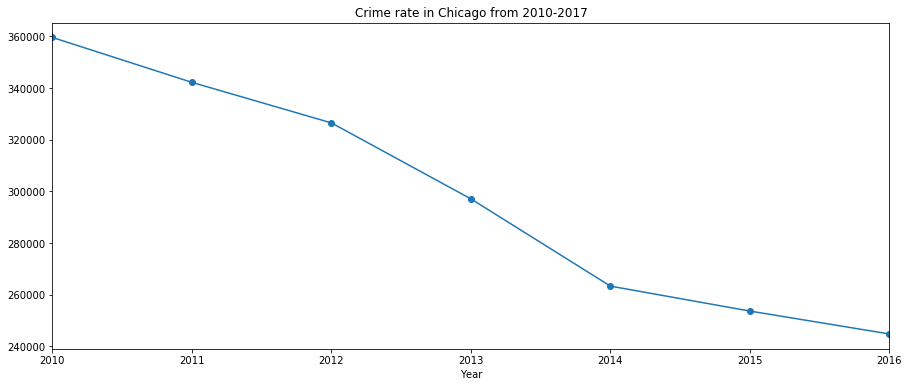

In [6]:
df_by_year = df.groupby("Year").count().ID
df_by_year.plot(title="Crime rate in Chicago from 2010-2017", marker='o')

It seems that the trend in number of crimes is going down. However let's see the same data by monthly.

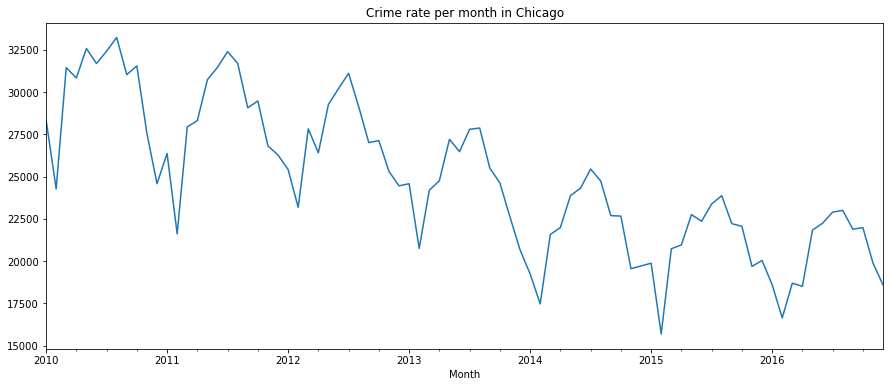

In [7]:
df_by_month = df.groupby("Month").count().ID
df_by_month.plot(title="Crime rate per month in Chicago")

Clearly much more fluctuations but the trend still seems to be going down. There also exists seasonal trends, as for example crime rates are lowest just after the New Year, but highest around summertime.

Next, to get clearer picture areal differences, lets compare ZIP-areas with lowest and highest crime rates side by side.